## Import Packages

In [118]:
import pygame
import numpy as np
import matplotlib.pyplot as plt #for analyzing sychronization level
import cmath
import random
from moviepy.editor import ImageSequenceClip

## Initialize pygame

In [119]:
pygame.init()
width, height = 800, 300 # window size
screen = pygame.display.set_mode((width, height))
clock = pygame.time.Clock()

## Tree & Firefly Parameters

In [120]:
num_trees = 15
fireflies_per_tree = 5
K = 10
time_steps = 500
tree_y_fixed = height - 100  # fix y position for trees on "x-axis"
ground_height = 100  # ground area height
min_tree_distance = 30  # minimum distance between trees

## Minimum Tree Distance

In [121]:
def is_position_valid(new_pos, existing_positions, min_distance):
    ''' asserts a minimum distance between trees to prevent overlap
    
        new_pos = position of tree currently being placed
        existing_positions = positions of trees already displayed
        min_distance = minimum distance parameter between trees
    '''
    for pos in existing_positions:
        dist = np.sqrt((new_pos[0] - pos[0])**2 + (new_pos[1] - pos[1])**2) # difference in x coord **2 + difference in y coord **2
        if dist < min_distance:
            return False # position not valid
    return True # position valid

## Generate Trees

In [122]:
tree_positions = [] #init empty list

while len(tree_positions) < num_trees: #generate trees until reach num_trees parameter
    new_tree_x = random.randint(50, width - 50) # randomly distribute trees between boundary of 50 and total width - 50
    new_tree_y = tree_y_fixed # fix them to x-axis
    new_tree_pos = (new_tree_x, new_tree_y)
    
    # add position only if it's valid from minimum tree distance
    if is_position_valid(new_tree_pos, tree_positions, min_tree_distance):
        tree_positions.append(new_tree_pos)

## Generate Fireflies

In [123]:
# init empty list
fireflies = []
phases = []
phase_velocities = []
frequencies = []

for (tree_x, tree_y) in tree_positions: # for each tree
    for _ in range(fireflies_per_tree):
        # firefly position with a small random offset around the tree along y-axis and x-axis
        offset_x = random.randint(-15, 15)
        offset_y = random.randint(-15, 15)
        fireflies.append((tree_x + offset_x, tree_y + offset_y))
        
        # random initial phases and natural frequencies
        phases.append(random.uniform(0, 2 * np.pi)) #uniformly spread out between 0 and 2pi
        frequencies.append(np.random.normal(0, 0.1)) # " " 0 and 0.1
        
synchronization_levels = [] #init list for synchronization levels

## Coupling Strength

Affect each other by relationship: $\frac{1}{\sqrt{(x_1 - x_2)^2 ~+~ (y_1 - y_2)^2}}$

In [124]:
def coupling_strength(pos1, pos2, max_radius=20):
    dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    
    if dist < max_radius:
        return 1  # maximum influence within max_radius
    else:
        return 1 / dist  # Slower decay for distances beyond max_radius

## Order Parameter

In [125]:
def calculate_order_parameter(phases):
    ''' calculates order parameter r(t)
        phases = takes in phase angle of each oscillator
    '''
    complex_sum = sum(cmath.exp(1j * theta) for theta in phases) # calculates e^i*theta 
    return abs(complex_sum) / len(phases) #total sum of all phase angles represented as points on the unit circle

## Main Loop

In [126]:
frames = []
fps = 30

running = True
t = 0

while running and t < time_steps:
    for event in pygame.event.get():
        if event.type == pygame.QUIT: # quit if window closes
            running = False

    # fill screen with background color (sky)
    screen.fill((0, 29, 61))  # Dark blue for night sky

    # draw ground
    pygame.draw.rect(screen, (34, 139, 34), (0, height - ground_height, width, ground_height))  # Green ground

    # draw trees
    for (tree_x, tree_y) in tree_positions:
        pygame.draw.rect(screen, (139, 69, 19), (tree_x - 5, tree_y, 10, 30))  # tree trunk
        pygame.draw.circle(screen, (34, 139, 34), (tree_x, tree_y - 15), 20)   # tree foliage

    # update phases based on the Kuramoto model with distance-based decay
    current_velocities = []
    num_fireflies = len(fireflies)

    for i in range(num_fireflies):
        pos_i = fireflies[i] #retrieve positon of firefly
        phase_i = phases[i] #retrieve phase of firefly
        coupling_sum = 0 #init variable to accumulate phase coupling affect from other fireflies
        
        for j in range(num_fireflies): # loop over all other fireflies
            if i != j: # firefly doesn't influence themselves
                pos_j = fireflies[j]
                phase_j = phases[j]
                
                # apply distance-based coupling decay
                G_ij = coupling_strength(pos_i, pos_j) #calculate coupling strength between firefly i and firefly j 
                # add weighted phase difference to coupling_sum
                coupling_sum += G_ij * np.sin(phase_j - phase_i) # sin(phase_j - phase_i) = phase difference

        # update phase based on coupling sum
        phase_velocity = frequencies[i] + (K / num_fireflies) * coupling_sum
        current_velocities.append(phase_velocity)

        phases[i] += phase_velocity
        #phases[i] += frequencies[i] + (K / num_fireflies) * coupling_sum

    phase_velocities.append(current_velocities)
    # calculate synchronization level
    r_t = calculate_order_parameter(phases)
    synchronization_levels.append(r_t)

    # draw fireflies near their assigned tree positions
    for index, (x, y) in enumerate(fireflies):
        # map phase to yellow intensity
        #1 + cos/2 changes bounds on cos from -1,1 to 0,1 -- multiply by 255 to get an intensity value between 0 and 255
        intensity = int(255 * (1 + np.cos(phases[index])) / 2)  # from 0 (black) to 255 (yellow)
        color = (intensity, intensity, 0) # (R, G, B)
        pygame.draw.circle(screen, color, (x, y), 5) #firefly as circle

    pygame.display.flip()
    frame = pygame.surfarray.array3d(screen)  # Capture the screen content as a numpy array
    frame = np.rot90(frame)  # Rotate for correct orientation
    frame = np.flipud(frame)  # Flip vertically for correct orientation
    frames.append(frame)  # Append to frames list

    clock.tick(30)  # control frame rate
    t += 1

pygame.quit()

clip = ImageSequenceClip(frames, fps=fps)
clip.write_videofile("firefly_simulation.mp4", codec="libx264")

Moviepy - Building video firefly_simulation.mp4.
Moviepy - Writing video firefly_simulation.mp4



Moviepy - Done !
Moviepy - video ready firefly_simulation.mp4


## Plot Synchronization Levels over time

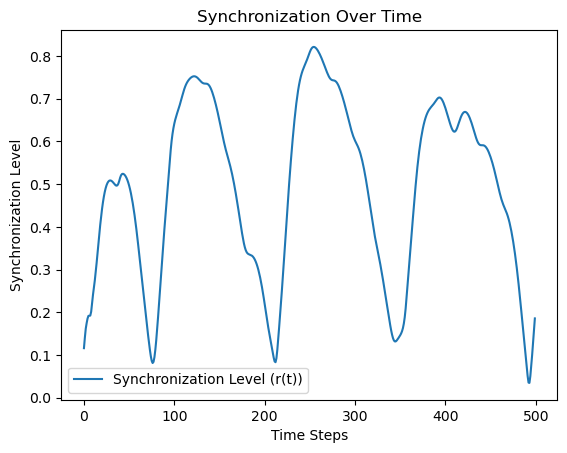

In [127]:
# Plot synchronization levels over time using matplotlib
plt.plot(synchronization_levels, label="Synchronization Level (r(t))")
plt.xlabel("Time Steps")
plt.ylabel("Synchronization Level")
plt.title("Synchronization Over Time")
plt.legend()
plt.show()

## Local Phase Coherence Graphs

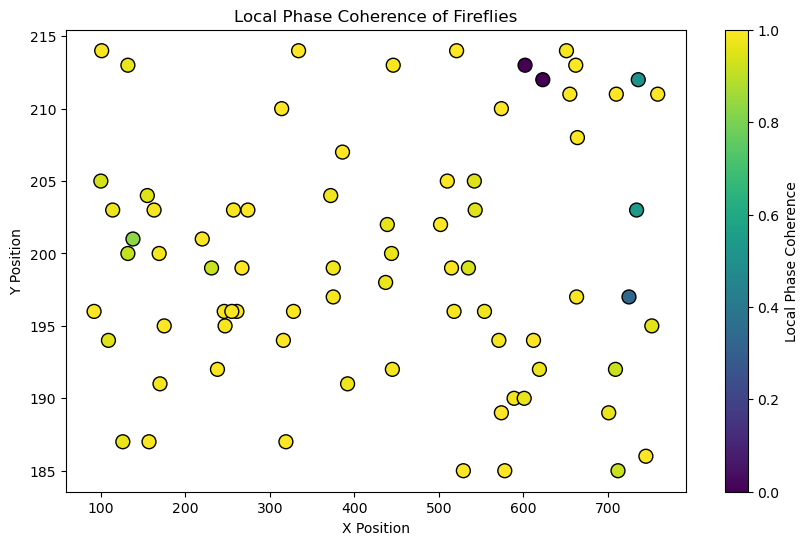

In [128]:
def local_phase_coherence(firefly_positions, phases, radius=20):
    """
    Calculate local phase coherence for each oscillator based on nearby oscillators.
    
    firefly_positions: List of (x, y) positions of each oscillator
    phases: List of phases for each oscillator
    radius: Distance within which to consider neighbors
    """
    num_fireflies = len(firefly_positions)
    local_coherences = np.zeros(num_fireflies)
    
    for i in range(num_fireflies):
        neighbors = []
        
        for j in range(num_fireflies):
            if i != j:
                # distance btw fireflies
                dist = np.sqrt((firefly_positions[i][0] - firefly_positions[j][0]) ** 2 +
                               (firefly_positions[i][1] - firefly_positions[j][1]) ** 2)
                
                if dist <= radius:
                    neighbors.append(j)
        
        if neighbors:
            # calculate local coherence as mean phase alignment with neighbors
            phase_diffs = [np.exp(1j * (phases[j] - phases[i])) for j in neighbors]
            local_coherences[i] = np.abs(np.mean(phase_diffs))
    
    return local_coherences  # local cohearance values for each firefly

local_coherences = local_phase_coherence(fireflies, phases, radius=20)



# Plotting the local phase coherence

plt.figure(figsize=(10, 6))

sc = plt.scatter(*zip(*fireflies), c=local_coherences, cmap='viridis', s=100, edgecolor='k')

plt.colorbar(sc, label='Local Phase Coherence')

plt.title("Local Phase Coherence of Fireflies")

plt.xlabel("X Position")

plt.ylabel("Y Position")

plt.show()


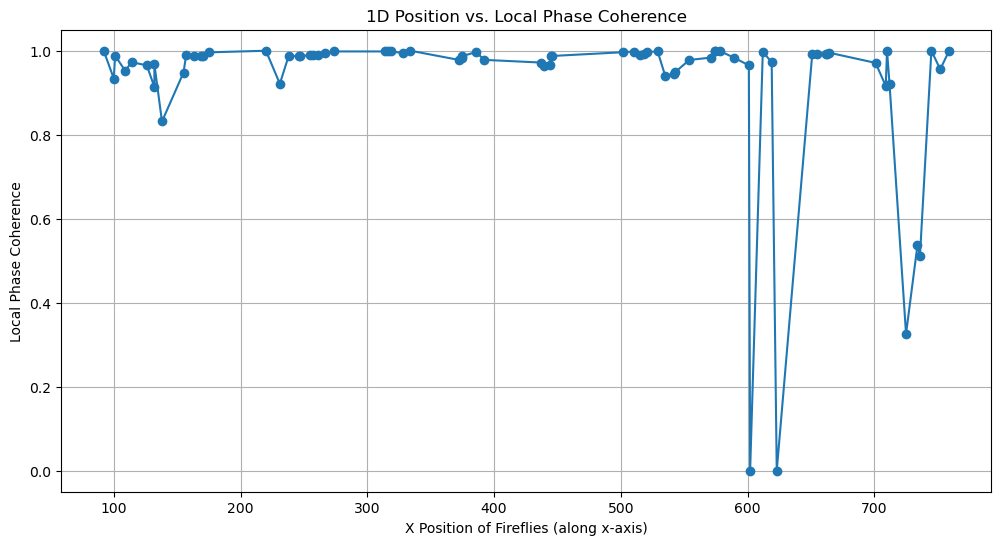

In [129]:
# Sort fireflies by their x-position to plot local phase coherence in 1D
firefly_positions_sorted = sorted(fireflies, key=lambda pos: pos[0])
x_positions = [pos[0] for pos in firefly_positions_sorted]

# Recalculate local phase coherence for sorted positions if needed
local_coherences_sorted = [local_coherences[i] for i in np.argsort([pos[0] for pos in fireflies])]

# 1D Position vs. Coherence Plot
plt.figure(figsize=(12, 6))
plt.plot(x_positions, local_coherences_sorted, marker='o', linestyle='-')
plt.title("1D Position vs. Local Phase Coherence")
plt.xlabel("X Position of Fireflies (along x-axis)")
plt.ylabel("Local Phase Coherence")
plt.grid(True)
plt.show()


## Average Phase Velocity Analysis

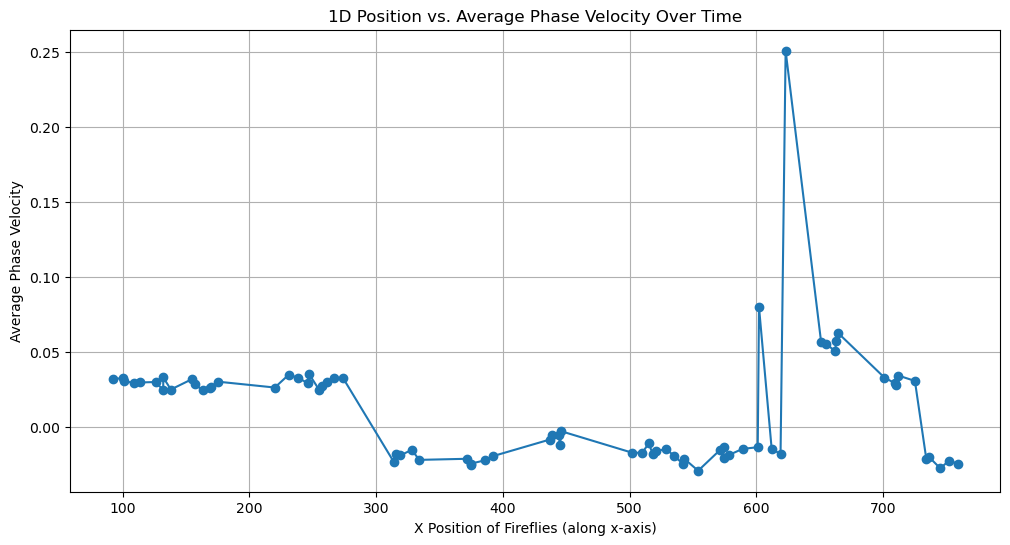

In [130]:
# average phase velocity for each firefly
avg_phase_velocity_over_time = np.mean(phase_velocities, axis=0)

#isolate x position
firefly_positions_sorted = sorted(fireflies, key=lambda pos: pos[0])
x_positions = [pos[0] for pos in firefly_positions_sorted]
avg_phase_velocity_sorted = [avg_phase_velocity_over_time[i] for i in np.argsort([pos[0] for pos in fireflies])]

# plotting
plt.figure(figsize=(12, 6))
plt.plot(x_positions, avg_phase_velocity_sorted, marker='o', linestyle='-')
plt.title("1D Position vs. Average Phase Velocity Over Time")
plt.xlabel("X Position of Fireflies (along x-axis)")
plt.ylabel("Average Phase Velocity")
plt.show()


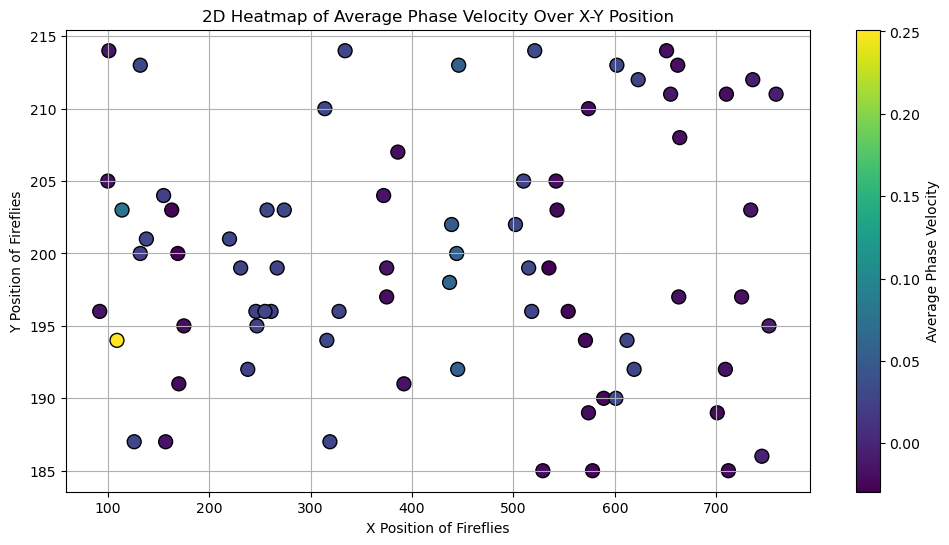

In [132]:
plt.figure(figsize=(12, 6))

firefly_x_positions = [pos[0] for pos in fireflies]

firefly_y_positions = [pos[1] for pos in fireflies]

sc = plt.scatter(firefly_x_positions, firefly_y_positions, c=avg_phase_velocity_sorted, cmap='viridis', s=100, edgecolor='k')

plt.colorbar(sc, label="Average Phase Velocity")

plt.title("2D Heatmap of Average Phase Velocity Over X-Y Position")

plt.xlabel("X Position of Fireflies")

plt.ylabel("Y Position of Fireflies")

plt.grid(True)

plt.show()